In [ ]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [ ]:
# Check the GPU type

!nvidia-smi

Thu Jun 12 23:33:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P8             14W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
import math

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange


In [ ]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [ ]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, dropout_last=True):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if dropout_last else nn.Identity(),
            nn.ReLU(inplace=True),
        ], skip)


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64

        self.timestep_embed = FourierFeatures(1, 16, std=0.2)
        self.class_embed = nn.Embedding(10, 4)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(1 + 16 + 4, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),
                    ResConvBlock(c * 2, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),
                        ResConvBlock(c * 4, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        nn.Upsample(scale_factor=2),
                    ]),
                    ResConvBlock(c * 8, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    nn.Upsample(scale_factor=2),
                ]),
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2),
            ]),
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 1, dropout_last=False),
        )

    def forward(self, input, log_snrs, cond):
        timestep_embed = expand_to_planes(self.timestep_embed(log_snrs[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond), input.shape)
        return self.net(torch.cat([input, class_embed, timestep_embed], dim=1))


In [ ]:
# Define the noise schedule and sampling loop

def get_alphas_sigmas(log_snrs):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given the log SNR for a timestep."""
    return log_snrs.sigmoid().sqrt(), log_snrs.neg().sigmoid().sqrt()


def get_ddpm_schedule(t):
    """Returns log SNRs for the noise schedule from the DDPM paper."""
    return -torch.special.expm1(1e-4 + 10 * t**2).log()


@torch.no_grad()
def sample(model, x, steps, eta, classes, mask_param=None):
    ts = x.new_ones([x.shape[0]])
    t = torch.linspace(1, 0, steps + 1)[:-1]
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)

    for i in trange(steps):
        with torch.cuda.amp.autocast():
            v = model(x, ts * log_snrs[i], classes).float()

        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        if i < steps - 1:
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                         (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            x = pred * alphas[i + 1] + eps * adjusted_sigma

            if eta:
                noise = torch.randn_like(x)

                if mask_param is not None:
                    # Frequency domain masking
                    noise_freq = torch.fft.fft2(noise, norm='ortho')
                    mask = mask_param.expand_as(noise_freq).to(noise.device)
                    noise_freq_masked = noise_freq * mask
                    noise = torch.fft.ifft2(noise_freq_masked, norm='ortho').real

                x += noise * ddim_sigma

    return pred



In [ ]:
from torchvision.datasets import MNIST

batch_size = 100

tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

train_set = datasets.MNIST('data', train=True, download=True, transform=tf)
val_set = datasets.MNIST('data', train=False, download=True, transform=tf)

train_dl = data.DataLoader(train_set, batch_size, shuffle=True,
                           num_workers=2, persistent_workers=True, pin_memory=True)
val_dl = data.DataLoader(val_set, batch_size,
                         num_workers=2, persistent_workers=True, pin_memory=True)


In [ ]:
from copy import deepcopy
import torch.optim as optim

seed = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(seed)

# Diffusion model
model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

# Time-independent learnable frequency mask
init_value = 0.5 + 0.01 * torch.randn((1, 1, 32, 32))
mask_param = nn.Parameter(init_value)

# Debugging
with torch.no_grad():
    m = mask_param[0, 0]
    print("Mean      :", m.mean().item())
    print("Std       :", m.std().item())
    print("Min       :", m.min().item())
    print("Max       :", m.max().item())




# Optimizer: model + mask
opt = optim.Adam([
    {'params': model.parameters()},
    {'params': [mask_param], 'lr': 1e-5}
], lr=2e-4)

scaler = torch.cuda.amp.GradScaler()
epoch = 0

# Quasi-random timestep sampler
rng = torch.quasirandom.SobolEngine(1, scramble=True)


Using device: cuda
Model parameters: 23208753
Mean      : 0.5001523494720459
Std       : 0.009680063463747501
Min       : 0.4698463976383209
Max       : 0.5286864638328552


<ipython-input-8-790453875>:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-9-3419497988>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation: Epoch: 0, loss: 0.290918

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-399176926>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


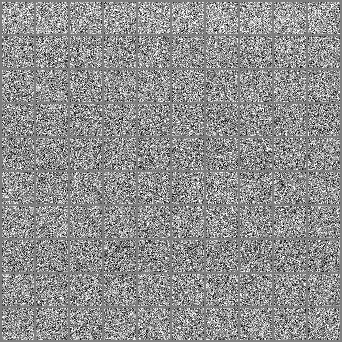

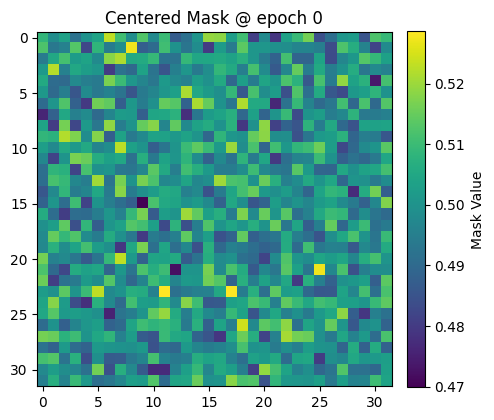

Epoch 0


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 0, iteration: 0, loss: 0.292877
Epoch: 0, iteration: 50, loss: 0.139795
Epoch: 0, iteration: 100, loss: 0.0845345
Epoch: 0, iteration: 150, loss: 0.0543799
Epoch: 0, iteration: 200, loss: 0.0518085
Epoch: 0, iteration: 250, loss: 0.0447553
Epoch: 0, iteration: 300, loss: 0.0530081
Epoch: 0, iteration: 350, loss: 0.0399211
Epoch: 0, iteration: 400, loss: 0.0470533
Epoch: 0, iteration: 450, loss: 0.0405893
Epoch: 0, iteration: 500, loss: 0.0424142
Epoch: 0, iteration: 550, loss: 0.0336806

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 1, loss: 0.0312976

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

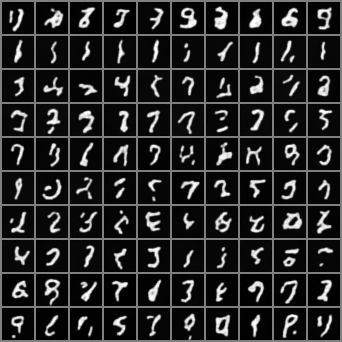

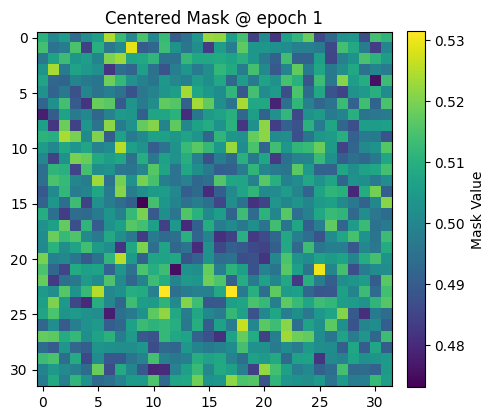

Epoch 1


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 1, iteration: 0, loss: 0.0442046
Epoch: 1, iteration: 50, loss: 0.0356125
Epoch: 1, iteration: 100, loss: 0.0361787
Epoch: 1, iteration: 150, loss: 0.0307465
Epoch: 1, iteration: 200, loss: 0.0314289
Epoch: 1, iteration: 250, loss: 0.0301213
Epoch: 1, iteration: 300, loss: 0.0333729
Epoch: 1, iteration: 350, loss: 0.0311981
Epoch: 1, iteration: 400, loss: 0.0284003
Epoch: 1, iteration: 450, loss: 0.0305285
Epoch: 1, iteration: 500, loss: 0.0280373
Epoch: 1, iteration: 550, loss: 0.0331956

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 2, loss: 0.0249581

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

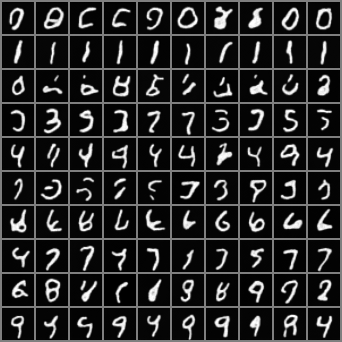

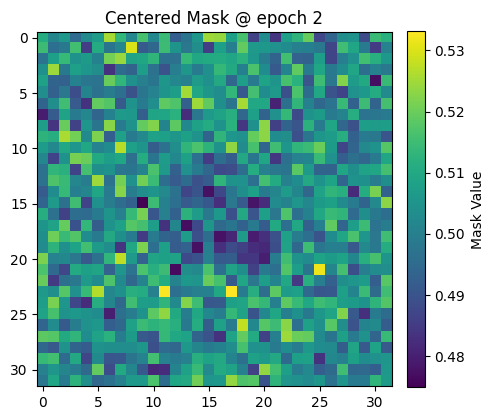

Epoch 2


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 2, iteration: 0, loss: 0.0288053
Epoch: 2, iteration: 50, loss: 0.0276715
Epoch: 2, iteration: 100, loss: 0.0286779
Epoch: 2, iteration: 150, loss: 0.0271491
Epoch: 2, iteration: 200, loss: 0.0272708
Epoch: 2, iteration: 250, loss: 0.0299688
Epoch: 2, iteration: 300, loss: 0.0273793
Epoch: 2, iteration: 350, loss: 0.0254565
Epoch: 2, iteration: 400, loss: 0.0243825
Epoch: 2, iteration: 450, loss: 0.0240979
Epoch: 2, iteration: 500, loss: 0.0283223
Epoch: 2, iteration: 550, loss: 0.0255245
Epoch 3


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 3, iteration: 0, loss: 0.0247479
Epoch: 3, iteration: 50, loss: 0.0240314
Epoch: 3, iteration: 100, loss: 0.0280792
Epoch: 3, iteration: 150, loss: 0.0239449
Epoch: 3, iteration: 200, loss: 0.0309539
Epoch: 3, iteration: 250, loss: 0.0237349
Epoch: 3, iteration: 300, loss: 0.0268134
Epoch: 3, iteration: 350, loss: 0.0231824
Epoch: 3, iteration: 400, loss: 0.0292271
Epoch: 3, iteration: 450, loss: 0.0260215
Epoch: 3, iteration: 500, loss: 0.0262907
Epoch: 3, iteration: 550, loss: 0.0219816

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 4, loss: 0.0207447

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

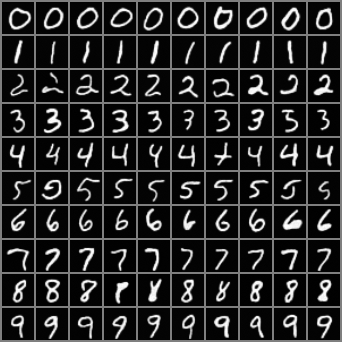

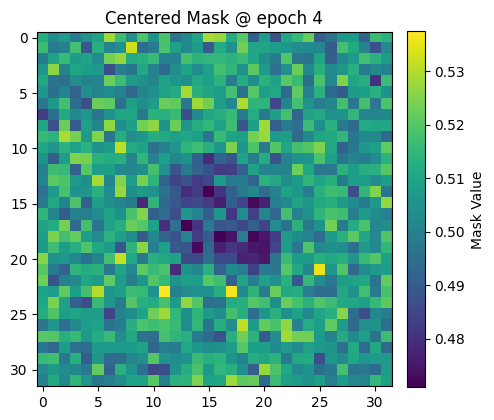

Epoch 4


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 4, iteration: 0, loss: 0.0214417
Epoch: 4, iteration: 50, loss: 0.0214584
Epoch: 4, iteration: 100, loss: 0.0245692
Epoch: 4, iteration: 150, loss: 0.0230378
Epoch: 4, iteration: 200, loss: 0.020428
Epoch: 4, iteration: 250, loss: 0.0221678
Epoch: 4, iteration: 300, loss: 0.0220648
Epoch: 4, iteration: 350, loss: 0.0227761
Epoch: 4, iteration: 400, loss: 0.0230601
Epoch: 4, iteration: 450, loss: 0.0231429
Epoch: 4, iteration: 500, loss: 0.0226735
Epoch: 4, iteration: 550, loss: 0.0202053
Epoch 5


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 5, iteration: 0, loss: 0.0239564
Epoch: 5, iteration: 50, loss: 0.0241222
Epoch: 5, iteration: 100, loss: 0.019374
Epoch: 5, iteration: 150, loss: 0.0214022
Epoch: 5, iteration: 200, loss: 0.0223553
Epoch: 5, iteration: 250, loss: 0.0220138
Epoch: 5, iteration: 300, loss: 0.025501
Epoch: 5, iteration: 350, loss: 0.018889
Epoch: 5, iteration: 400, loss: 0.0214739
Epoch: 5, iteration: 450, loss: 0.0208859
Epoch: 5, iteration: 500, loss: 0.0236606
Epoch: 5, iteration: 550, loss: 0.018954

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 6, loss: 0.0193273

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

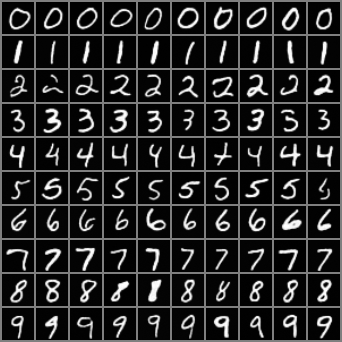

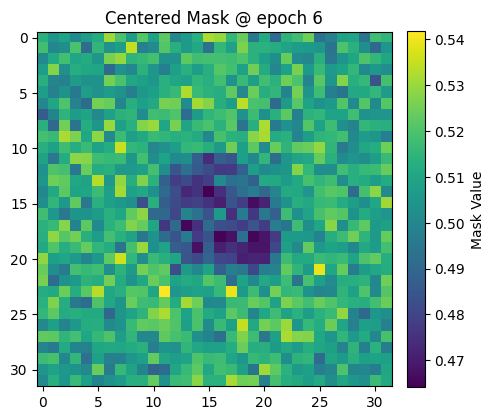

Epoch 6


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 6, iteration: 0, loss: 0.0253089
Epoch: 6, iteration: 50, loss: 0.020296
Epoch: 6, iteration: 100, loss: 0.0260071
Epoch: 6, iteration: 150, loss: 0.021144
Epoch: 6, iteration: 200, loss: 0.0226148
Epoch: 6, iteration: 250, loss: 0.0228758
Epoch: 6, iteration: 300, loss: 0.0220342
Epoch: 6, iteration: 350, loss: 0.0197112
Epoch: 6, iteration: 400, loss: 0.0225957
Epoch: 6, iteration: 450, loss: 0.0206393
Epoch: 6, iteration: 500, loss: 0.0222586
Epoch: 6, iteration: 550, loss: 0.0213171
Epoch 7


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 7, iteration: 0, loss: 0.0203681
Epoch: 7, iteration: 50, loss: 0.0209388
Epoch: 7, iteration: 100, loss: 0.0223197
Epoch: 7, iteration: 150, loss: 0.0224283
Epoch: 7, iteration: 200, loss: 0.0190831
Epoch: 7, iteration: 250, loss: 0.022142
Epoch: 7, iteration: 300, loss: 0.0212371
Epoch: 7, iteration: 350, loss: 0.020769
Epoch: 7, iteration: 400, loss: 0.022533
Epoch: 7, iteration: 450, loss: 0.0217732
Epoch: 7, iteration: 500, loss: 0.0201854
Epoch: 7, iteration: 550, loss: 0.0208344

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 8, loss: 0.018512

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

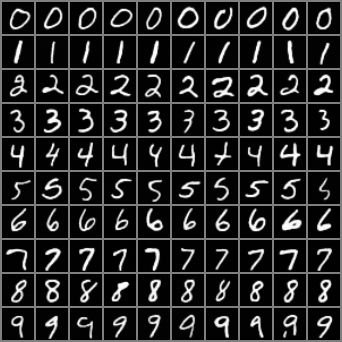

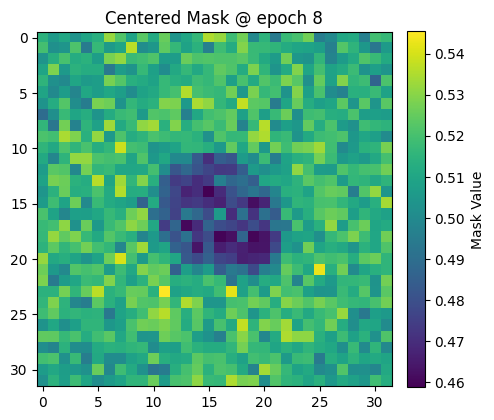

Epoch 8


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 8, iteration: 0, loss: 0.0201194
Epoch: 8, iteration: 50, loss: 0.0200648
Epoch: 8, iteration: 100, loss: 0.0223363
Epoch: 8, iteration: 150, loss: 0.0197198
Epoch: 8, iteration: 200, loss: 0.0199327
Epoch: 8, iteration: 250, loss: 0.0199745
Epoch: 8, iteration: 300, loss: 0.0216051
Epoch: 8, iteration: 350, loss: 0.0222359
Epoch: 8, iteration: 400, loss: 0.0213019
Epoch: 8, iteration: 450, loss: 0.019408
Epoch: 8, iteration: 500, loss: 0.0237193
Epoch: 8, iteration: 550, loss: 0.0190215
Epoch 9


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 9, iteration: 0, loss: 0.0214808
Epoch: 9, iteration: 50, loss: 0.0183268
Epoch: 9, iteration: 100, loss: 0.0211703
Epoch: 9, iteration: 150, loss: 0.0206305
Epoch: 9, iteration: 200, loss: 0.018706
Epoch: 9, iteration: 250, loss: 0.0204377
Epoch: 9, iteration: 300, loss: 0.0210067
Epoch: 9, iteration: 350, loss: 0.0200415
Epoch: 9, iteration: 400, loss: 0.0186587
Epoch: 9, iteration: 450, loss: 0.0210293
Epoch: 9, iteration: 500, loss: 0.0192409
Epoch: 9, iteration: 550, loss: 0.0237355

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 10, loss: 0.0180083

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

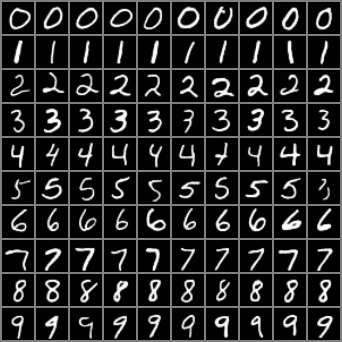

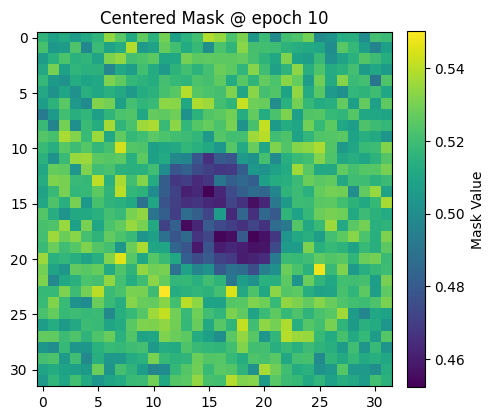

Epoch 10


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 10, iteration: 0, loss: 0.019202
Epoch: 10, iteration: 50, loss: 0.021783
Epoch: 10, iteration: 100, loss: 0.0187116
Epoch: 10, iteration: 150, loss: 0.0214823
Epoch: 10, iteration: 200, loss: 0.0212125
Epoch: 10, iteration: 250, loss: 0.020337
Epoch: 10, iteration: 300, loss: 0.0200196
Epoch: 10, iteration: 350, loss: 0.0199699
Epoch: 10, iteration: 400, loss: 0.0207767
Epoch: 10, iteration: 450, loss: 0.018531
Epoch: 10, iteration: 500, loss: 0.0214181
Epoch: 10, iteration: 550, loss: 0.0179966
Epoch 11


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 11, iteration: 0, loss: 0.0210398
Epoch: 11, iteration: 50, loss: 0.0187042
Epoch: 11, iteration: 100, loss: 0.0214299
Epoch: 11, iteration: 150, loss: 0.0191662
Epoch: 11, iteration: 200, loss: 0.0225497
Epoch: 11, iteration: 250, loss: 0.020957
Epoch: 11, iteration: 300, loss: 0.0195293
Epoch: 11, iteration: 350, loss: 0.0201138
Epoch: 11, iteration: 400, loss: 0.0207446
Epoch: 11, iteration: 450, loss: 0.0190588
Epoch: 11, iteration: 500, loss: 0.0201824
Epoch: 11, iteration: 550, loss: 0.0170877

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 12, loss: 0.0175411

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

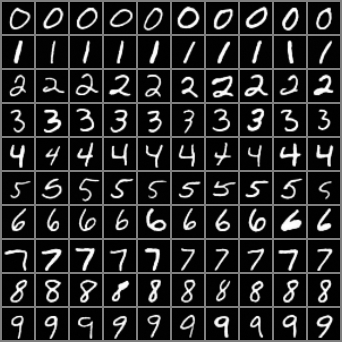

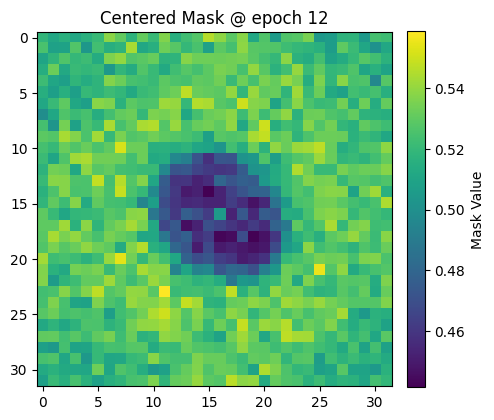

Epoch 12


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 12, iteration: 0, loss: 0.0193025
Epoch: 12, iteration: 50, loss: 0.0205051
Epoch: 12, iteration: 100, loss: 0.0206591
Epoch: 12, iteration: 150, loss: 0.0190423
Epoch: 12, iteration: 200, loss: 0.0164872
Epoch: 12, iteration: 250, loss: 0.019626
Epoch: 12, iteration: 300, loss: 0.0194302
Epoch: 12, iteration: 350, loss: 0.0200032
Epoch: 12, iteration: 400, loss: 0.0197788
Epoch: 12, iteration: 450, loss: 0.0198992
Epoch: 12, iteration: 500, loss: 0.0198734
Epoch: 12, iteration: 550, loss: 0.0193474
Epoch 13


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 13, iteration: 0, loss: 0.0201301
Epoch: 13, iteration: 50, loss: 0.0229745
Epoch: 13, iteration: 100, loss: 0.0182702
Epoch: 13, iteration: 150, loss: 0.0189581
Epoch: 13, iteration: 200, loss: 0.0191486
Epoch: 13, iteration: 250, loss: 0.0186422
Epoch: 13, iteration: 300, loss: 0.0191647
Epoch: 13, iteration: 350, loss: 0.016529
Epoch: 13, iteration: 400, loss: 0.0179258
Epoch: 13, iteration: 450, loss: 0.0182951
Epoch: 13, iteration: 500, loss: 0.0202754
Epoch: 13, iteration: 550, loss: 0.0197603

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 14, loss: 0.0174238

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

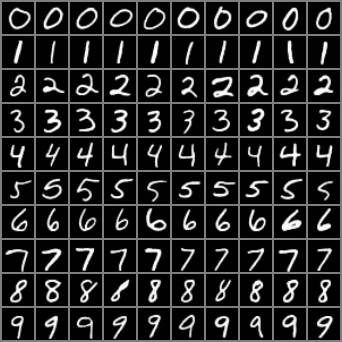

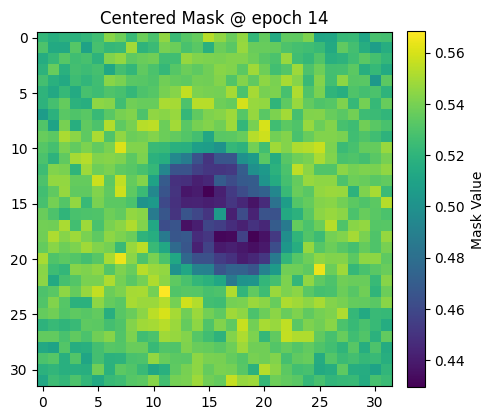

Epoch 14


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 14, iteration: 0, loss: 0.0231623
Epoch: 14, iteration: 50, loss: 0.0165338
Epoch: 14, iteration: 100, loss: 0.0204927
Epoch: 14, iteration: 150, loss: 0.0189175
Epoch: 14, iteration: 200, loss: 0.0194098
Epoch: 14, iteration: 250, loss: 0.0171925
Epoch: 14, iteration: 300, loss: 0.0190828
Epoch: 14, iteration: 350, loss: 0.0163801
Epoch: 14, iteration: 400, loss: 0.0178197
Epoch: 14, iteration: 450, loss: 0.0158319
Epoch: 14, iteration: 500, loss: 0.020117
Epoch: 14, iteration: 550, loss: 0.0185273
Epoch 15


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 15, iteration: 0, loss: 0.0187257
Epoch: 15, iteration: 50, loss: 0.0197993
Epoch: 15, iteration: 100, loss: 0.0172371
Epoch: 15, iteration: 150, loss: 0.0188994
Epoch: 15, iteration: 200, loss: 0.0185109
Epoch: 15, iteration: 250, loss: 0.0196478
Epoch: 15, iteration: 300, loss: 0.0185789
Epoch: 15, iteration: 350, loss: 0.0215315
Epoch: 15, iteration: 400, loss: 0.01899
Epoch: 15, iteration: 450, loss: 0.0187074
Epoch: 15, iteration: 500, loss: 0.0170674
Epoch: 15, iteration: 550, loss: 0.0192761

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 16, loss: 0.0170003

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

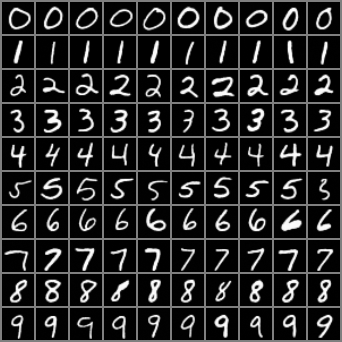

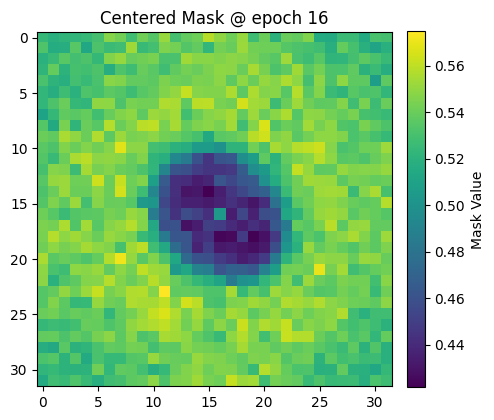

Epoch 16


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 16, iteration: 0, loss: 0.018722
Epoch: 16, iteration: 50, loss: 0.0175963
Epoch: 16, iteration: 100, loss: 0.0192038
Epoch: 16, iteration: 150, loss: 0.0188123
Epoch: 16, iteration: 200, loss: 0.0197939
Epoch: 16, iteration: 250, loss: 0.0176968
Epoch: 16, iteration: 300, loss: 0.0223619
Epoch: 16, iteration: 350, loss: 0.0184023
Epoch: 16, iteration: 400, loss: 0.0217309
Epoch: 16, iteration: 450, loss: 0.0175266
Epoch: 16, iteration: 500, loss: 0.0218801
Epoch: 16, iteration: 550, loss: 0.0166113
Epoch 17


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 17, iteration: 0, loss: 0.0181925
Epoch: 17, iteration: 50, loss: 0.0192985
Epoch: 17, iteration: 100, loss: 0.0197122
Epoch: 17, iteration: 150, loss: 0.0175779
Epoch: 17, iteration: 200, loss: 0.0181932
Epoch: 17, iteration: 250, loss: 0.0164505
Epoch: 17, iteration: 300, loss: 0.0200243
Epoch: 17, iteration: 350, loss: 0.0181099
Epoch: 17, iteration: 400, loss: 0.0172666
Epoch: 17, iteration: 450, loss: 0.0188942
Epoch: 17, iteration: 500, loss: 0.0182717
Epoch: 17, iteration: 550, loss: 0.0185541

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 18, loss: 0.0167706

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

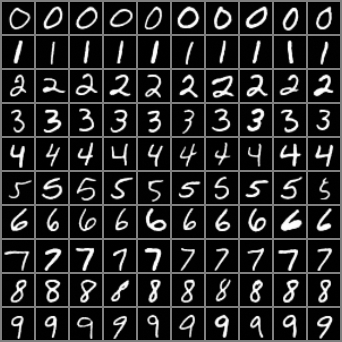

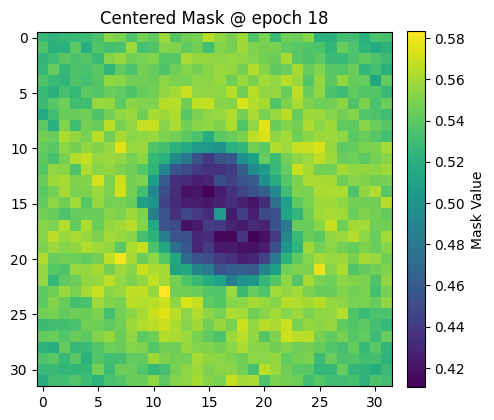

Epoch 18


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 18, iteration: 0, loss: 0.0181504
Epoch: 18, iteration: 50, loss: 0.0207663
Epoch: 18, iteration: 100, loss: 0.0199066
Epoch: 18, iteration: 150, loss: 0.0187551
Epoch: 18, iteration: 200, loss: 0.0169667
Epoch: 18, iteration: 250, loss: 0.0201249
Epoch: 18, iteration: 300, loss: 0.0186514
Epoch: 18, iteration: 350, loss: 0.0184903
Epoch: 18, iteration: 400, loss: 0.0171785
Epoch: 18, iteration: 450, loss: 0.0176873
Epoch: 18, iteration: 500, loss: 0.0199287
Epoch: 18, iteration: 550, loss: 0.0172955
Epoch 19


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 19, iteration: 0, loss: 0.0198875
Epoch: 19, iteration: 50, loss: 0.0174117
Epoch: 19, iteration: 100, loss: 0.0182621
Epoch: 19, iteration: 150, loss: 0.0170291
Epoch: 19, iteration: 200, loss: 0.0191897
Epoch: 19, iteration: 250, loss: 0.0184717
Epoch: 19, iteration: 300, loss: 0.0209865
Epoch: 19, iteration: 350, loss: 0.0166369
Epoch: 19, iteration: 400, loss: 0.0199307
Epoch: 19, iteration: 450, loss: 0.0185365
Epoch: 19, iteration: 500, loss: 0.0190019
Epoch: 19, iteration: 550, loss: 0.0169887

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 20, loss: 0.0165999

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

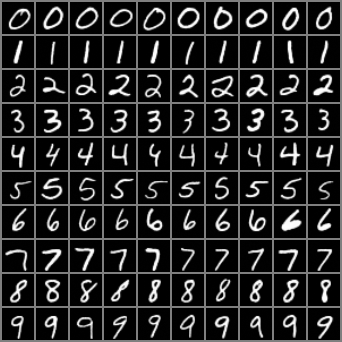

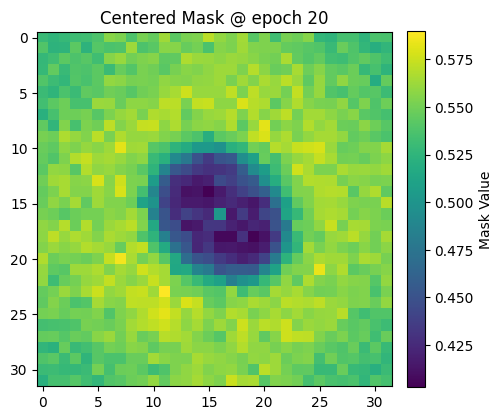

Epoch 20


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 20, iteration: 0, loss: 0.0185835
Epoch: 20, iteration: 50, loss: 0.0168197
Epoch: 20, iteration: 100, loss: 0.0204041
Epoch: 20, iteration: 150, loss: 0.0185878
Epoch: 20, iteration: 200, loss: 0.0188735
Epoch: 20, iteration: 250, loss: 0.0177808
Epoch: 20, iteration: 300, loss: 0.0169053
Epoch: 20, iteration: 350, loss: 0.02206
Epoch: 20, iteration: 400, loss: 0.0180453
Epoch: 20, iteration: 450, loss: 0.0190719
Epoch: 20, iteration: 500, loss: 0.0186022
Epoch: 20, iteration: 550, loss: 0.0197515
Epoch 21


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 21, iteration: 0, loss: 0.0179865
Epoch: 21, iteration: 50, loss: 0.0200298
Epoch: 21, iteration: 100, loss: 0.0187342
Epoch: 21, iteration: 150, loss: 0.0189264
Epoch: 21, iteration: 200, loss: 0.0179013
Epoch: 21, iteration: 250, loss: 0.0170423
Epoch: 21, iteration: 300, loss: 0.0190269
Epoch: 21, iteration: 350, loss: 0.0179158
Epoch: 21, iteration: 400, loss: 0.0181186
Epoch: 21, iteration: 450, loss: 0.0177015
Epoch: 21, iteration: 500, loss: 0.0191682
Epoch: 21, iteration: 550, loss: 0.0155025

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 22, loss: 0.0162844

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

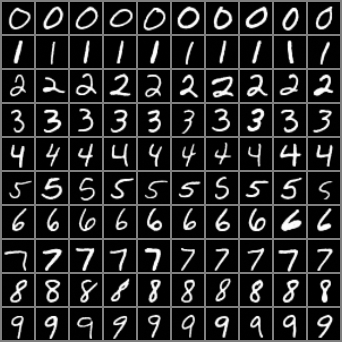

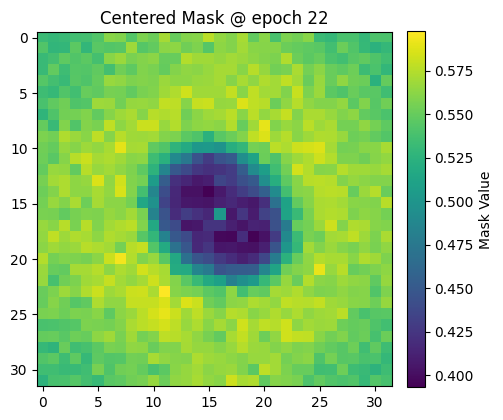

Epoch 22


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 22, iteration: 0, loss: 0.0187775
Epoch: 22, iteration: 50, loss: 0.0191135
Epoch: 22, iteration: 100, loss: 0.0205538
Epoch: 22, iteration: 150, loss: 0.0176053
Epoch: 22, iteration: 200, loss: 0.0193226
Epoch: 22, iteration: 250, loss: 0.0183198
Epoch: 22, iteration: 300, loss: 0.0194564
Epoch: 22, iteration: 350, loss: 0.0167351
Epoch: 22, iteration: 400, loss: 0.0187314
Epoch: 22, iteration: 450, loss: 0.0180599
Epoch: 22, iteration: 500, loss: 0.0186683
Epoch: 22, iteration: 550, loss: 0.0179804
Epoch 23


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 23, iteration: 0, loss: 0.017194
Epoch: 23, iteration: 50, loss: 0.0182525
Epoch: 23, iteration: 100, loss: 0.0183052
Epoch: 23, iteration: 150, loss: 0.0197028
Epoch: 23, iteration: 200, loss: 0.016993
Epoch: 23, iteration: 250, loss: 0.0189027
Epoch: 23, iteration: 300, loss: 0.0194526
Epoch: 23, iteration: 350, loss: 0.0163797
Epoch: 23, iteration: 400, loss: 0.0172139
Epoch: 23, iteration: 450, loss: 0.0206658
Epoch: 23, iteration: 500, loss: 0.0168554
Epoch: 23, iteration: 550, loss: 0.0170701

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 24, loss: 0.0161555

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

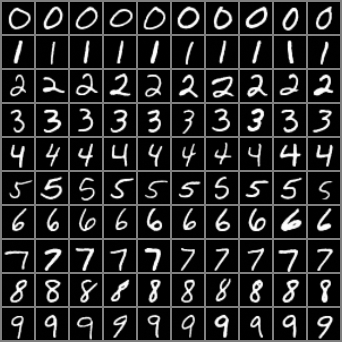

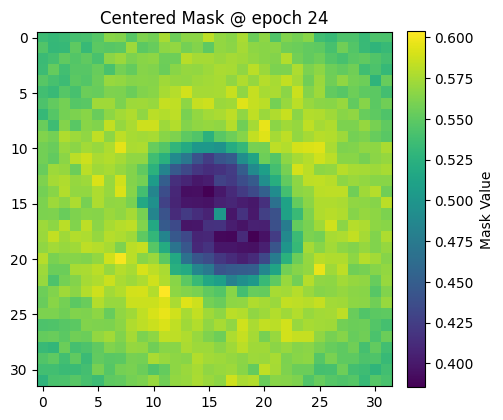

Epoch 24


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 24, iteration: 0, loss: 0.0166425
Epoch: 24, iteration: 50, loss: 0.0178617
Epoch: 24, iteration: 100, loss: 0.0173659
Epoch: 24, iteration: 150, loss: 0.0164619
Epoch: 24, iteration: 200, loss: 0.0193911
Epoch: 24, iteration: 250, loss: 0.014895
Epoch: 24, iteration: 300, loss: 0.021702
Epoch: 24, iteration: 350, loss: 0.017808
Epoch: 24, iteration: 400, loss: 0.0233274
Epoch: 24, iteration: 450, loss: 0.0173215
Epoch: 24, iteration: 500, loss: 0.018244
Epoch: 24, iteration: 550, loss: 0.0169226
Epoch 25


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 25, iteration: 0, loss: 0.0188188
Epoch: 25, iteration: 50, loss: 0.0179795
Epoch: 25, iteration: 100, loss: 0.0182516
Epoch: 25, iteration: 150, loss: 0.01613
Epoch: 25, iteration: 200, loss: 0.0187381
Epoch: 25, iteration: 250, loss: 0.018429
Epoch: 25, iteration: 300, loss: 0.0173947
Epoch: 25, iteration: 350, loss: 0.018919
Epoch: 25, iteration: 400, loss: 0.0187686
Epoch: 25, iteration: 450, loss: 0.0172931
Epoch: 25, iteration: 500, loss: 0.0191493
Epoch: 25, iteration: 550, loss: 0.0206622

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 26, loss: 0.0160395

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

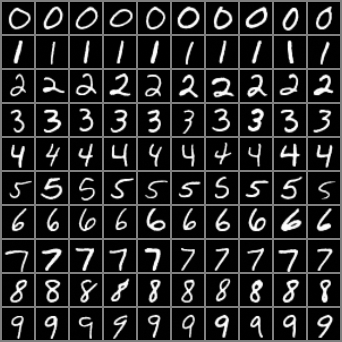

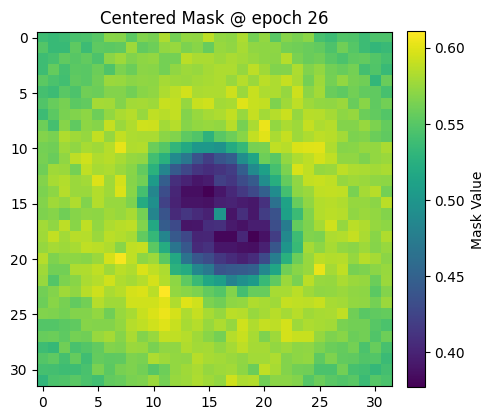

Epoch 26


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 26, iteration: 0, loss: 0.0176585
Epoch: 26, iteration: 50, loss: 0.0212861
Epoch: 26, iteration: 100, loss: 0.0180862
Epoch: 26, iteration: 150, loss: 0.0163279
Epoch: 26, iteration: 200, loss: 0.0192081
Epoch: 26, iteration: 250, loss: 0.0181344
Epoch: 26, iteration: 300, loss: 0.0158569
Epoch: 26, iteration: 350, loss: 0.019508
Epoch: 26, iteration: 400, loss: 0.0168081
Epoch: 26, iteration: 450, loss: 0.0171308
Epoch: 26, iteration: 500, loss: 0.0171688
Epoch: 26, iteration: 550, loss: 0.0157098
Epoch 27


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 27, iteration: 0, loss: 0.0176196
Epoch: 27, iteration: 50, loss: 0.0167707
Epoch: 27, iteration: 100, loss: 0.0193975
Epoch: 27, iteration: 150, loss: 0.0184888
Epoch: 27, iteration: 200, loss: 0.01706
Epoch: 27, iteration: 250, loss: 0.0174829
Epoch: 27, iteration: 300, loss: 0.0200118
Epoch: 27, iteration: 350, loss: 0.0173239
Epoch: 27, iteration: 400, loss: 0.0203516
Epoch: 27, iteration: 450, loss: 0.0165347
Epoch: 27, iteration: 500, loss: 0.0169699
Epoch: 27, iteration: 550, loss: 0.0167552

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 28, loss: 0.0159247

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

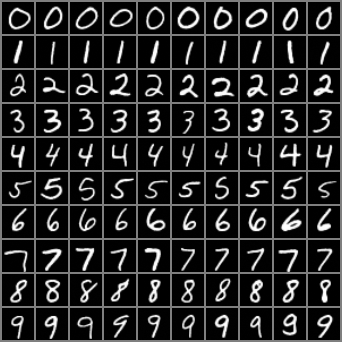

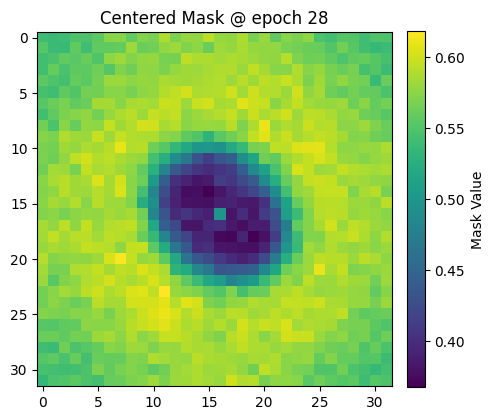

Epoch 28


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 28, iteration: 0, loss: 0.0185243
Epoch: 28, iteration: 50, loss: 0.0163598
Epoch: 28, iteration: 100, loss: 0.018992
Epoch: 28, iteration: 150, loss: 0.0171609
Epoch: 28, iteration: 200, loss: 0.0146237
Epoch: 28, iteration: 250, loss: 0.0182592
Epoch: 28, iteration: 300, loss: 0.0175202
Epoch: 28, iteration: 350, loss: 0.0190617
Epoch: 28, iteration: 400, loss: 0.0172687
Epoch: 28, iteration: 450, loss: 0.0181354
Epoch: 28, iteration: 500, loss: 0.0168617
Epoch: 28, iteration: 550, loss: 0.0187361
Epoch 29


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 29, iteration: 0, loss: 0.0167673
Epoch: 29, iteration: 50, loss: 0.0188668
Epoch: 29, iteration: 100, loss: 0.0175072
Epoch: 29, iteration: 150, loss: 0.0161198
Epoch: 29, iteration: 200, loss: 0.0173461
Epoch: 29, iteration: 250, loss: 0.0170787
Epoch: 29, iteration: 300, loss: 0.0191171
Epoch: 29, iteration: 350, loss: 0.0148669
Epoch: 29, iteration: 400, loss: 0.0185594
Epoch: 29, iteration: 450, loss: 0.0162347
Epoch: 29, iteration: 500, loss: 0.0195494
Epoch: 29, iteration: 550, loss: 0.0171063

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 30, loss: 0.0158152

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

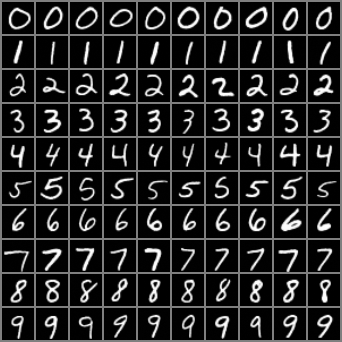

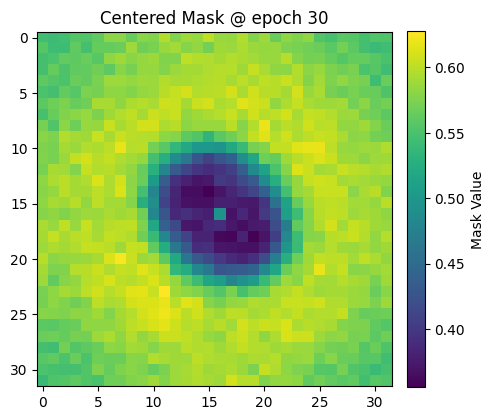

In [ ]:
# Actually train the model

ema_decay = 0.998

# The number of timesteps to use when sampling
steps = 500

NUM_EPOCHS = 30

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.

#Save loss
train_loss_list = []
val_loss_list = []


def eval_loss(model, rng, reals, classes):
    B = reals.shape[0]
    t = rng.draw(B)[:, 0].to(device)
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)
    weights = log_snrs.exp() / log_snrs.exp().add(1)

    alphas_ = alphas[:, None, None, None]
    sigmas_ = sigmas[:, None, None, None]
    noise = torch.randn_like(reals)

    # Frequency masking (FFT domain)
    x0_freq = torch.fft.fft2(reals, norm='ortho')
    eps_freq = torch.fft.fft2(noise, norm='ortho')
    mask = torch.sigmoid(mask_param).expand(B, 1, 32, 32).to(reals.device)
    eps_freq = eps_freq * mask
    xt_freq = x0_freq * alphas_ + eps_freq * sigmas_
    xt = torch.fft.ifft2(xt_freq, norm='ortho').real  # [B, C, H, W]

    targets = noise * alphas_ - reals * sigmas_

    with torch.cuda.amp.autocast():
        v = model(xt, log_snrs, classes)
        return (v - targets).pow(2).mean([1, 2, 3]).mul(weights).mean()



def train():
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(train_dl)):

        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals, classes)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        total_loss += loss.item() * len(reals)
        count += len(reals)

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')

    avg_loss = total_loss / count
    train_loss_list.append(avg_loss)



@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(val_dl)):
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model_ema, rng, reals, classes)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    loss = total_loss / count
    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')
    return loss

@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)

    noise = torch.randn([100, 1, 32, 32], device=device)
    fakes_classes = torch.arange(10, device=device).repeat_interleave(10, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes, mask_param=mask_param)

    grid = utils.make_grid(fakes, 10).cpu()
    filename = f'demo_{epoch:05}.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    tqdm.write('')


def save():
    filename = 'mnist_diffusion.pth'
    obj = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'opt': opt.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch,
    }
    torch.save(obj, filename)


from torch.fft import fftshift

@torch.no_grad()
def visualize_mask(mask_param, epoch=0, save=False):
    import matplotlib.pyplot as plt
    from torch.fft import fftshift

    mask = mask_param[0, 0].detach().cpu()
    mask = fftshift(mask)

    plt.figure(figsize=(5, 5))
    im = plt.imshow(mask.numpy(), cmap='viridis')
    plt.title(f"Centered Mask @ epoch {epoch}")
    plt.colorbar(im, fraction=0.046, pad=0.04, label='Mask Value')

    #plt.axis('off')
    if save:
        plt.savefig(f"mask_epoch_{epoch:03}.png", bbox_inches='tight')
    else:
        plt.show()
    plt.close()




try:
    val()
    demo()
    visualize_mask(mask_param, epoch=epoch, save=False)
    while epoch<NUM_EPOCHS:
        print('Epoch', epoch)
        train()
        epoch += 1
        if epoch % 2 == 0 or epoch == 1:
            val_loss = val()
            val_loss_list.append(val_loss)
            demo()
            visualize_mask(mask_param, epoch=epoch, save=False)
        torch.save(mask_param.detach().cpu(), f"mask_epoch_{epoch:03}.pt")
        save()
except KeyboardInterrupt:
    pass


Mask Visualization

No mask_epoch_000.pt file detected


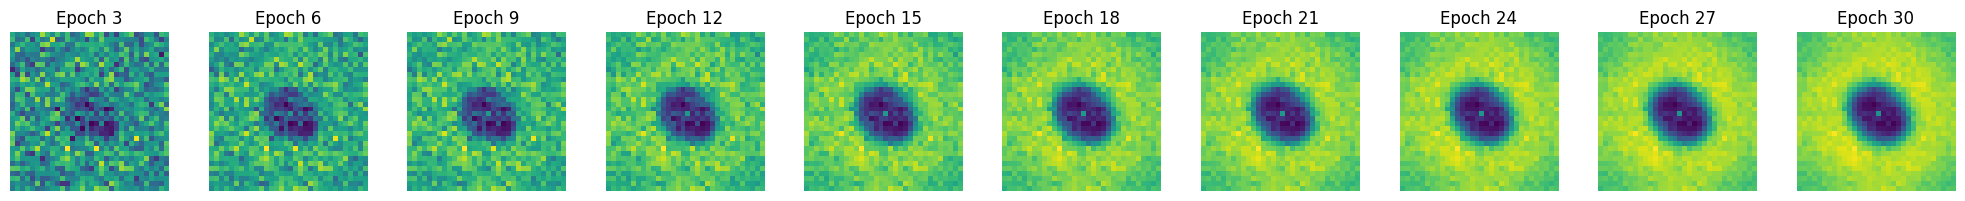

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fftshift

num_snapshots = 8
snapshot_epochs = np.linspace(0, NUM_EPOCHS, num_snapshots + 1, endpoint=True, dtype=int).tolist()

loaded_masks = {}
for epoch in snapshot_epochs:
    path = f"mask_epoch_{epoch:03}.pt"
    try:
        mask_tensor = torch.load(path, map_location='cpu')
        mask_np = mask_tensor[0, 0].numpy()
        loaded_masks[epoch] = fftshift(mask_np)
    except FileNotFoundError:
         print(f"No {path} file detected")
         continue

N = len(loaded_masks)
fig, axes = plt.subplots(1, N, figsize=(N * 2, 2))

for i, epoch in enumerate(loaded_masks):
    mask = loaded_masks[epoch]
    ax = axes[i] if N > 1 else axes
    im = ax.imshow(mask, cmap='viridis')
    ax.set_title(f"Epoch {epoch}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("mask_evolution_all.png", dpi=300, bbox_inches='tight')
plt.show()


FID

In [ ]:
!pip install clean-fid

In [ ]:
import os
from torchvision.utils import save_image

@torch.no_grad()
@eval_mode(model_ema)
def generate_many_samples(output_dir='fid_fake_images', total=1000, batch_size=100, mask_param=None):
    """
    Generates MNIST diffusion samples using model_ema and saves them as images.

    Args:
        output_dir (str): Directory to save images.
        total (int): Total number of images to generate.
        batch_size (int): Images per batch.
        mask_param (torch.Tensor): Learnable frequency mask to apply in sampling.
    """
    os.makedirs(output_dir, exist_ok=True)
    model_ema.eval()

    for i in range(0, total, batch_size):
        noise = torch.randn([batch_size, 1, 32, 32], device=device)
        classes = torch.randint(0, 10, (batch_size,), device=device)

        samples = sample(model_ema, noise, steps, eta, classes, mask_param=mask_param)
        samples = (samples.clamp(-1, 1) + 1) / 2

        for j in range(samples.size(0)):
            save_image(samples[j], os.path.join(output_dir, f"sample_{i+j:05}.png"))


In [ ]:
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import os
import torchvision.transforms as transforms
from cleanfid import fid

def save_mnist_real_images(output_dir="fid_real_images", total=1000):
    os.makedirs(output_dir, exist_ok=True)
    dataset = MNIST(root=".", train=False, download=True)
    for i in range(total):
        img, _ = dataset[i]
        img_tensor = transforms.ToTensor()(img)
        save_image(img_tensor, os.path.join(output_dir, f"real_{i:05}.png"))

generate_many_samples(output_dir="fid_fake_images", total=10000, batch_size=100, mask_param=mask_param)

save_mnist_real_images(output_dir='fid_real_images', total=10000)

fid_score = fid.compute_fid("fid_fake_images", "fid_real_images")
print(f"FID score: {fid_score:.2f}")


  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-399176926>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

compute FID between two folders
Found 18100 images in the folder fid_fake_images


FID fid_fake_images : 100%|██████████| 566/566 [01:42<00:00,  5.50it/s]


Found 10000 images in the folder fid_real_images


FID fid_real_images : 100%|██████████| 313/313 [01:00<00:00,  5.20it/s]


FID score: 57.26


In [ ]:
import shutil

shutil.rmtree("fid_fake_images")
shutil.rmtree("fid_real_images")
print("Temporary folders deleted.")

Temporary folders deleted.


Visualize reverse process


In [ ]:
@torch.no_grad()
@eval_mode(model_ema)
def visualize_reverse_trajectory_learnable_mask(labels, mask_param, total_steps=500, vis_steps=20, save_path=None):
    """
    Visualizes the reverse denoising process for multiple digit classes,
    applying the learnable frequency mask to injected noise at each step.
    """
    import matplotlib.pyplot as plt

    num_rows = len(labels)
    t = torch.linspace(1, 0, total_steps)
    log_snrs = get_ddpm_schedule(t.to(device))
    alphas, sigmas = get_alphas_sigmas(log_snrs)
    selected_idxs = torch.linspace(0, total_steps - 1, vis_steps).long().tolist()

    mask = torch.sigmoid(mask_param).detach()
    mask = mask.expand(1, 1, 32, 32)  # [1,1,H,W]

    all_images = []

    for label in labels:
        class_label = torch.tensor([label], device=device)
        x = torch.randn(1, 1, 32, 32, device=device)

        row_images = []
        for i in range(total_steps):
            ts = log_snrs[i].expand(1)
            v = model_ema(x, ts, class_label)

            pred = x * alphas[i] - v * sigmas[i]
            eps = x * sigmas[i] + v * alphas[i]

            if i < total_steps - 1:
                ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                             (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
                adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

                x = pred * alphas[i + 1] + eps * adjusted_sigma

                if eta > 0:
                    noise = torch.randn_like(x)
                    noise_fft = torch.fft.fft2(noise, norm='ortho')
                    noise_fft = noise_fft * mask.to(noise.device)
                    filtered_noise = torch.fft.ifft2(noise_fft, norm='ortho').real

                    x += filtered_noise * ddim_sigma
            else:
                x = pred

            if i in selected_idxs:
                row_images.append((x.clamp(-1, 1) + 1) / 2)

        all_images.append(row_images)

    fig, axes = plt.subplots(
        num_rows, vis_steps,
        figsize=(vis_steps, num_rows),
        gridspec_kw=dict(wspace=0.05, hspace=0.0)
    )

    for r in range(num_rows):
        for c in range(vis_steps):
            img = all_images[r][c][0].detach().cpu().squeeze().numpy()
            ax = axes[r, c] if num_rows > 1 else axes[c]
            ax.imshow(img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            if r == num_rows - 1:
                ax.set_xlabel(f"T={selected_idxs[c]}", fontsize=6)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")
    else:
        plt.show()

    plt.close()


NameError: name 'torch' is not defined

  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-6-399176926>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


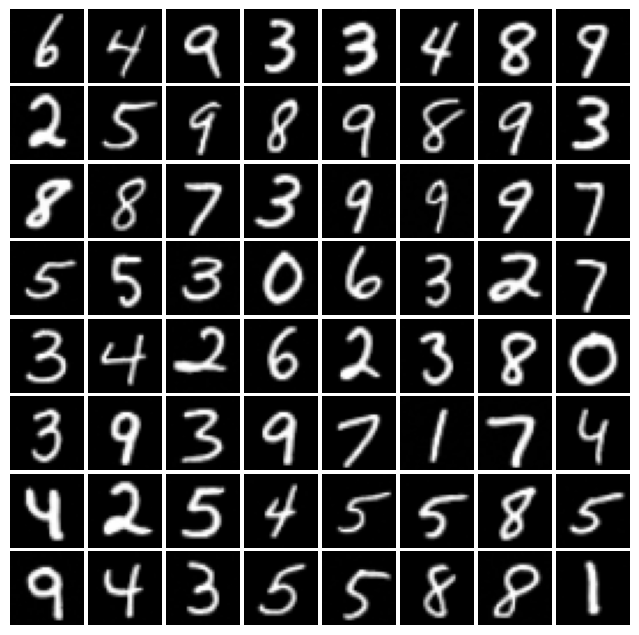

In [ ]:
@torch.no_grad()
@eval_mode(model_ema)
def generate_and_save_samples(save_path='sample_figure.png'):
    """
    Generate 64 samples from the trained diffusion model (MNIST) and save as a figure.
    """
    model_ema.eval()

    classes = torch.randint(0, 10, (64,), device=device)
    noise = torch.randn([64, 1, 32, 32], device=device)

    samples = sample(model_ema, noise, steps, eta, classes, mask_param=mask_param)
    samples = (samples.clamp(-1, 1) + 1) / 2

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            idx = i * 8 + j
            img = samples[idx].detach().cpu().squeeze().numpy()
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

generate_and_save_samples('final_samples_64.png')


In [ ]:
@torch.no_grad()
@eval_mode(model_ema)
def generate_and_save_samples(save_path='sample_figure.png', rows=8, cols=8):

    model_ema.eval()

    num_samples = rows * cols
    classes = torch.randint(0, 10, (num_samples,), device=device)
    noise = torch.randn([num_samples, 1, 32, 32], device=device)

    samples = sample(model_ema, noise, steps, eta, classes, mask_param=mask_param)
    samples = (samples.clamp(-1, 1) + 1) / 2

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            img = samples[idx].detach().cpu().squeeze().numpy()
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [ ]:
generate_and_save_samples(save_path='mnist_grid_10x6.png', rows=15, cols=15)

generate_and_save_samples('sample_4x4.png', rows=8, cols=8)
